# Preliminaries

Relevant links: 
- [Gaussian Processes for Machine Learning - CH 2](https://gaussianprocess.org/gpml/chapters/RW2.pdf)

In [1]:
using LinearAlgebra
using Distributions 
using Random
using Plots

First let's set up some data that we can use for training our Guassian Process Regressor

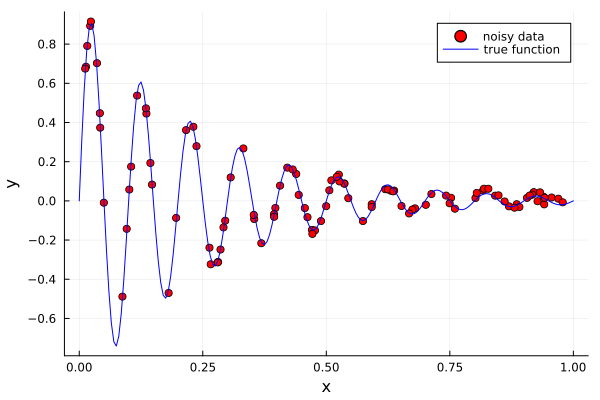

In [2]:
# the noisy function we want to fit
function make_training_data(n, ν)
    xs = 0:0.005:1 # for plotting
    X = rand(n) 
    
    y(x) = (exp(-x/(0.5)^2) * sin(2π*ν*x)) + (0.25)^2*(rand()-0.5)
    ytrue(x) = exp(-x/(0.5)^2) * sin(2π*ν*x)

    return X', y.(X), xs, ytrue.(xs)
end



X, y, xs, ytrue = make_training_data(100, 10)

plot(X', y, seriestype=:scatter, color=:red, label="noisy data")
plot!(xs,ytrue, color=:blue, label="true function")
xlabel!("x")
ylabel!("y")

# Weight-space View

There are two equivalent ways to arrive that the formulation for guassian process regression (GPR): 
1. The **weight-space** view 
2. The **function-space** view

We begin with the weight space view as it is a natural extension of standard linear regression when we make considerations for guassian distributed noise in observations. 

## Terminology 

We consider a training set, $\mathcal{D}$ with $n$ observations 
\begin{equation}
    \mathcal{D} = \left\{ (\mathbf{x}_i, y_i) \; \vert \; i=1,...,n \right\}
\end{equation}
- $\mathbf{x}_i$ is the ith, $D$-dimensional input (feature) vector 
- $y_i$ is the ith target

Linear regression is best accomplished via linear algebra. We therefore collect our dataset into a $D \times n$ dimensional **Design Matrix**
\begin{equation}
X := \begin{pmatrix} 
\vdots & \vdots & & \vdots \\ 
\mathbf{x}_1 & \mathbf{x}_2 & ... & \mathbf{x}_n \\
\vdots & \vdots & & \vdots 
\end{pmatrix}
\end{equation}

and our targets into a target vector

\begin{equation}
\mathbf{y} := (y_1, ..., y_n)
\end{equation}
so that the full training set becomes 
\begin{equation}
\mathcal{D} := (X, \mathbf{y})
\end{equation}

## The Standard Linear Model

Standard linear regression is a model of the form 
\begin{equation} 
f(x) = \mathbf{x}^T\mathbf{w} 
\end{equation} 
where the vector $\mathbf{w}$ is the $D$-dimensional vector of weights. By minimizing the mean-squared-error loss function, one can show that the optimal weights of the system are given by
\begin{equation}
\mathbf{w} = (XX^T)^{-1}X\mathbf{y}
\end{equation}

Note: this can also be easily obtained geometrically by finding the vector with the shortest distance to the hyperplane defined by the column space of $X$. This corresponds to solve the **Normal Equations** 
\begin{equation}
XX^T\mathbf{w} = X\mathbf{y} 
\end{equation}


The following demonstrates this procedure on some simple data

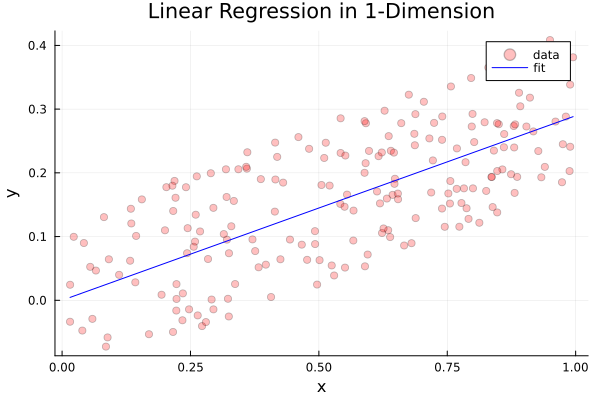

In [3]:
X = rand(200)
y = 0.3 .* X .+ 0.25 .* (rand(200) .- 0.5)
X = X'

w = (X*X')\(X*y)
ypred = X'*w

plot(X', y, 
    seriestype=:scatter,
    color=:red, alpha=0.25, 
    label="data")

plot!(X', ypred, color=:blue, label="fit")
xlabel!("x")
ylabel!("y")
title!("Linear Regression in 1-Dimension")

**Note**: We can also fit a y intercept (bias) by augmenting the input vector $X$  with an aditional element whose value is alwyas 1, i.e. setting 
\begin{equation} 
X[D+1, :] = (1, ..., 1)
\end{equation}

## Making it Bayesian

Standard linear regression assumes that our data $\mathcal{D}$ are perfect but we can clearly see that the above data are noisy. To account for this, we can make our model *Bayesian* by augmenting our model such that 
\begin{align} 
    f(\mathbf{x}) &= \mathbf{x}^T\mathbf{w} \\ 
    y &= f(\mathbf{x}) + \epsilon \\ 
    \epsilon &\sim \mathcal{N}(0, \sigma_n^2)
\end{align}

Here we are saying that the observed values differ from the *truth* by independent, identically distributed (i.i.d.) guassian noise with zero mean and variance $\sigma_n^2$

The noise model together with it's corresponding distribution allow us to consider the *likelihood*, that is, the probability density of our observations given the model parameters: 
\begin{align} 
p(\mathbf{y}\vert X,\mathbf{w}) &:= \prod\limits_i^n p(y_i \vert \mathbf{x}_i, \mathbf{w}) \\
&= \prod\limits_i^n \frac{1}{\sqrt{2\pi\sigma_n^2}}\exp\left( -\dfrac{(y_i-\mathbf{x}_i^T\mathbf{w})^2}{2\sigma_n^2}\right)\\
&= \dfrac{1}{(2\pi\sigma_n^2)^{n/2}}\exp\left( -\frac{1}{2\sigma_n^2}\lvert \mathbf{y} - X^T\mathbf{w}\rvert^2 \right) \\
&= \mathcal{N}\left(X^T\mathbf{w}, \sigma_n^2I\right)
\end{align} 


Because we are being Bayesians (and not frequentists), we are allowed to encode our assumptions about the distriubtion of possible parameter vectors $\mathbf{w}$ via a **Bayesian Prior**, that is 
\begin{equation}
    p(\mathbf{w}) = \mathcal{N}(\mathbf{0}, \Sigma_p)
\end{equation}

The reson for this particular choice will become clear in the following derivation. For now, let's just use it and see what happens. 

To perform inference with our updated model, we apply Baye's Rule, that is: 
\begin{equation}
p(\mathbf{w}\vert\mathbf{y}, X) = \dfrac{p(\mathbf{y}\vert X, \mathbf{w})p(\mathbf{w})}{p(\mathbf{y}\vert X)}
\end{equation}
where 
- $p(\mathbf{w}\vert\mathbf{y}, X)$ is the **posterior distribution** 
- $p(\mathbf{y}\vert X, \mathbf{w})$ is the **likelihood**
- $p(\mathbf{w})$ is the **prior distribution**
- $p(\mathbf{y}\vert X)$ is the **marginal likelihood**, i.e. the normalization constant

It is now that the utility of choosing gaussian distributions  for our likelihood and prior becomes clear... 
\begin{align}
p(\mathbf{w}\vert\mathbf{y},X) &\propto \exp\left(-\frac{1}{2\sigma_n^2}(\mathbf{y}-X^T\mathbf{w})^T(\mathbf{y}-X^T\mathbf{w}) \right)\exp\left(-\frac{1}{2}\mathbf{w}^T\Sigma_p^{-1}\mathbf{w}\right)
\end{align}
Taking the log and expanding leads to
\begin{align}
\log(p(\mathbf{w}\vert \mathbf{y}, X))&= \frac{1}{2}\left[ \frac{1}{\sigma_n^2}\mathbf{y}^T\mathbf{y} - \frac{1}{\sigma_n^2}\mathbf{y}^TX^T\mathbf{w} - \frac{1}{\sigma_n^2}\mathbf{w}^TX\mathbf{y} + \frac{1}{\sigma_n^2}\mathbf{w}^TXX^T\mathbf{w} + \mathbf{w}^T\Sigma_p^{-1}\mathbf{w}\right] \\
&= \frac{1}{2}\left[ \mathbf{w}^T\left(\frac{1}{\sigma_n^2}XX^T+\Sigma_p^{-1}\right)\mathbf{w} -\left(\frac{1}{\sigma_n^2}\mathbf{y}^TX^T\right)\mathbf{w} - \mathbf{w}^T\left(\frac{1}{\sigma_n^2}X\mathbf{y}\right)  + \mathbf{y}^T\frac{1}{\sigma_n^2}\mathbf{y}\right]\\ 
&= \mathbf{w}^TA\mathbf{w} - B^T\mathbf{w} - \mathbf{w}^TB + C
\end{align}
where we have defined
\begin{align}
A &:= \frac{1}{\sigma_n^2}XX^T + \Sigma_p^{-1} \\ 
B &:= \frac{1}{\sigma_n^2}X\mathbf{y} \\ 
C &:= \mathbf{y}^T\frac{1}{\sigma_n^2}\mathbf{y}
\end{align}

Now we can complete the square so that
\begin{equation}
\mathbf{w}^TA\mathbf{w} - B^T\mathbf{w} - \mathbf{w}^TB + C = \left(\mathbf{w} - \bar{\mathbf{w}} \right)^TA\left(\mathbf{w} - \bar{\mathbf{w}} \right) + K
\end{equation}
leading to 
\begin{align}
\bar{\mathbf{w}} &= A^{-1}B = \frac{1}{\sigma_n^2}\left(\frac{1}{\sigma_n^2}XX^T + \Sigma_p^{-1}\right)^{-1}X\mathbf{y} \\ 
K &= C- \bar{\mathbf{w}}^TA\bar{\mathbf{w}}
\end{align}
Since $K$ does not depend on $\mathbf{w}$ directly, it may be absorbed into the normalization of $p(\mathbf{w}\vert \mathbf{y}, X)$. Thus we are left with

--- 

\begin{align}
p(\mathbf{w}\vert\mathbf{y},X) &= \mathcal{N}\left( \bar{\mathbf{w}}=\frac{1}{\sigma_n^2}A^{-1}X\mathbf{y}, \Sigma=A^{-1}\right) \\ 
A &= \frac{1}{\sigma_n^2}XX^T+\Sigma_p^{-1}
\end{align}

---

This result gives us the gaussian distriubtion over the space of possible parameter vectors $\mathbf{w}$. To use this distribution to make predictions, consider a newly supplied testpoint $\mathbf{x}_*$. We want to find 
\begin{equation}
p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) 
\end{equation}

We do this by marginalizing over our weight distribution, i.e. 
\begin{equation}
p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) = \int_{\mathbf{w}} p(y_*\vert \mathbf{x}_*,\mathbf{w})p(\mathbf{w}\vert \mathbf{y}, X)d\mathbf{w}
\end{equation}
If we make the further assumption that testing points are i.i.d. guassian distriubted, we see that this integral is the product of two gaussians and therefore is also a guassian. To find the mean and covariance of the predictive distribution, we check 
\begin{align} 
    \bar{y}_* &= \mathbb{E}[y_*] = \mathbb{E}[\mathbf{x}_*^T\mathbf{w}] = \mathbf{x}_*^T\mathbb{E}[\mathbf{w}] = \mathbf{x}_*^T\bar{\mathbf{w}} \\ 
    \text{Cov}(y_*) &= \mathbb{E}[(y_*-\bar{y}_*)(y_*-\bar{y}_*)^T] \\ 
    &= \mathbb{E}[(\mathbf{x}_*^T\mathbf{w}-\mathbf{x}_*^T\bar{\mathbf{w}})(\mathbf{x}_*^T\mathbf{w}-\mathbf{x}_*^T\bar{\mathbf{w}})^T] \\ 
    &= \mathbb{E}[\mathbf{x}_*^T(\mathbf{w}-\bar{\mathbf{w}})(\mathbf{w}-\bar{\mathbf{w}})^T\mathbf{x}_*] \\ 
    &= \mathbf{x}_*^T\mathbb{E}[(\mathbf{w}-\bar{\mathbf{w}})(\mathbf{w}-\bar{\mathbf{w}})^T]\mathbf{x}_* \\ 
    &= \mathbf{x}_*^T\text{Cov}(\mathbf{w})\mathbf{x}_* \\
    &= \mathbf{x}_*^TA^{-1}\mathbf{x}_*
\end{align} 
so that 
\begin{equation}
\boxed{p(y_* \vert \mathbf{x}_*, \mathbf{y}, X) = \mathcal{N}\left(\mathbf{x}_*^T\mathbf{w},\;  \mathbf{x}_*^TA^{-1}\mathbf{x}_*\right)}
\end{equation}

# Doing More with Less: Kernelization

Let's take a break from our Bayesian regression and return to standard linear regression for a moment. The key drawback of linear models is, of course, that they're *linear*! Considering that many (most?) *interesting* relationships are not linear, how can we extend our simple linear model to enable us to perform complicated non-linear fits? 

In the parlance of machine learning, the simple solution is to do **Feature Engineering**. If our inital feature vector is 
\begin{equation}
\mathbf{x} = (x_1, ..., x_n) 
\end{equation}
we can use our *expertise* to concot new combinations of these features to produce the agumented vector 
\begin{equation}
\tilde{\mathbf{x}} = (x_1, ..., x_n, x_1^2, \;sin(x_2), \;x_5x_7/x_4,\;...) 
\end{equation}

As an example, a linear classifier is unable to distinguish points inside a circle from those outside just from the $(x,y)$ coordinates alone. Augmenting the feature vector to include the squared radius $x^2+y^2$ as a new feature removes this obstacle. 

## Generalizing our Regression Model

Constructing new features is often more art than science. To standardize the process, let's abstract mapping from the original feature vector $\mathbf{x}$ to the augmented vector $\tilde{\mathbf{x}}$. This is accomplished via the projection map $\phi:\mathbb{R}^D \to \mathbb{R}^N$ where
\begin{equation}
    \mathbf{x} \mapsto \tilde{\mathbf{x}} = \phi(\mathbf{x})
\end{equation}

The result is that our linear model updates to become 
\begin{equation}
f(\mathbf{x}) := \phi(\mathbf{x})^T\mathbf{w}
\end{equation}
where the weight vector has gone from $D$ dimensional to $N$ dimensional. 

Similarly, the normal equations for $\mathbf{w}$ update to become 
\begin{equation}
\mathbf{w} = (\Phi\Phi^T)^{-1}\Phi\mathbf{y}
\end{equation}
where $\Phi = \phi(X)$ is the $N\times n$ matrix resulting from applying $\phi$ columnwise to $X$. 

The following example shows how to use such a mapping to produce a quadratic polynomial fit. 

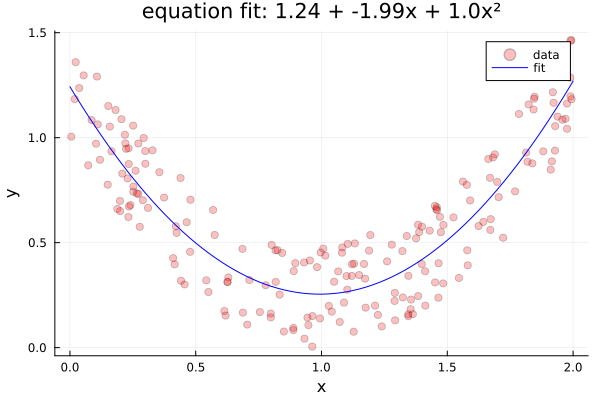

In [4]:
X = 2*rand(200)
y =  1.0 .- 2.0 .* X .+ X.^2 .+ (0.5 .* rand(200))
X = X'

# compute projection
Φ(x) = [1.0, x...,[x[i]*x[j] for i∈1:size(x,1) for j∈1:size(x,1)]...]
X̃ = hcat([Φ(col) for col ∈ eachcol(X)]...)

# fit the parameters
w = (X̃*X̃')\(X̃*y)

# compute projection on test points
Xpred = collect(0:0.025:2)
Xpred = Xpred'
X̃pred = hcat([Φ(col) for col ∈ eachcol(Xpred)]...)

# compute prediction on test points
ypred = X̃pred'*w

# visualize
plot(X', y, 
    seriestype=:scatter,
    color=:red, alpha=0.25, 
    label="data")

plot!(Xpred', ypred, color=:blue, label="fit")
xlabel!("x")
ylabel!("y")
title!("equation fit: $(round(w[1],digits=2)) + $(round(w[2], digits=2))x + $(round(w[3], digits=2))x²")



We see from the above that our linear regression model found a great fit for a 2nd order polynomial when supplied with polynomial features. 

Note: there is a *massive* problem with this method. Our order 2 polynomial map $\phi$ takes us from a $D$ dimenional feature vector to $(D+1)!$ many. This means that as we add more features to our feature map, the dimension of the resulting vector will quickly become prohibitively large. 


## Bayesian Regression with Feature Mappings 

Let's ignore the problem of dimensionality for the moment and update our Bayesian regression scheme to make use of our feature projection map $\phi$. First we define 
\begin{align} 
    \Phi &:= \phi(X) \\ 
    \phi_* &:= \phi(\mathbf{x}_*)
\end{align}

Our predictive distribution therefore becomes
\begin{align}
    p(y_* \vert \mathbf{x}_*, X, \mathbf{y}) &= \mathcal{N}\left(\frac{1}{\sigma_n^2}\phi_*^TA^{-1}\Phi\mathbf{y}, \;\phi_*^TA^{-1}\phi_*\right) \\ 
    A &= \frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}
\end{align}
Great! Now we can do our Bayesian inference with non-linear features given by $\phi$.

Returning to the problem of the dimensionality of our augmented feature vectors $\phi(\mathbf{x})$, we see that the computational bottleneck is the matrix inversion of $A$ which requires we invert an $N\times N$ matrix. 

Note that our prediction (i.e. the mean) involves multiplication on the right by the $n$ dimensional vector $\mathbf{y}$. With that in mind, perhaps we can reformulate the above into an equivalent form using at most an $n\times n$ dimensional matrix...

Let $K:= \Phi^T\Sigma_p\Phi$. Observe the following:
\begin{align} 
    \frac{1}{\sigma_n^2}\Phi(K+\sigma_n^2I) &= \frac{1}{\sigma_n^2}\Phi\left(\Phi^T\Sigma_p\Phi + \sigma_n^2I \right) \\ 
    &= \frac{1}{\sigma_n^2}\Phi\Phi^T\Sigma_p\Phi + \Phi I \\ 
    &= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T \right)\Sigma_p\Phi + \left(\Phi I \Phi^{-1}\Sigma_p^{-1} \right)\Sigma_p\Phi \\ 
    &= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}\right)\Sigma_p\Phi \\ 
    &= A\Sigma_p\Phi
\end{align}

From there we see that 
\begin{align} 
    A^{-1}\frac{1}{\sigma_n^2}\Phi\left(K+\sigma_n^2I\right) &= \Sigma_p\Phi \\ 
    \Rightarrow \frac{1}{\sigma_n^2}A^{-1}\Phi &= \Sigma_p\Phi\left(K + \sigma_n^2I\right)^{-1} \\ 
    \Rightarrow \frac{1}{\sigma_n^2}\phi_*^TA^{-1}\Phi &= \phi_*^T\Sigma_p\Phi\left(K + \sigma_n^2I\right)^{-1}
\end{align} 

For the covariance, we utilize the matrix inversion lemma which states 
\begin{equation}
 (Z + UWV^T)^{-1} = Z^{-1} - Z^{-1}U(W^{-1} + V^TZ^{-1}U)^{-1}V^TZ^{-1}
\end{equation}

With the identification 
\begin{align}
    Z^{-1} &\to \Sigma_p \\ 
    W^{-1} &\to \sigma_n^2I \\ 
    V &\to \Phi \\ 
    U &\to \Phi 
\end{align}
we find 
\begin{align}
\Sigma_p - \Sigma_p\Phi\left(\Sigma_p + \Phi^T\Sigma_p\Phi \right)^{-1}\Phi^T\Sigma_p  &= \left(\Sigma_p^{-1} + \Phi\frac{1}{\sigma_n^2}I\Phi^T\right)^{-1}\\ 
&= \left(\frac{1}{\sigma_n^2}\Phi\Phi^T + \Sigma_p^{-1}\right)^{-1}  \\ 
&= A^{-1} 
\end{align}

Thus, we have the equivalent form for our predictive distribution: 
\begin{equation}
\boxed{p(y_*\vert \mathbf{x}_*, X, \mathbf{y}) =\\ \mathcal{N}\left( \phi_*^T\Sigma_p\Phi(K+\sigma_n^2I)^{-1}\mathbf{y}, \; \phi_*^T\Sigma_p\phi_* - \phi_*^T\Sigma_p\Phi(K+\sigma_n^2I)^{-1}\Phi^T\Sigma_p\phi_*\right)}
\end{equation}

but the pesky $N\times N$ term has now been replaces by the $n\times n$ matrix $\Phi^T\Sigma_p\Phi$. 

## Kernelization

We now make the the *key* observation that the only matrices that appear in the above expression are 
\begin{align}
    &\Phi^T\Sigma_p\Phi &\phi_*^T\Sigma_p\phi_* \\ 
    &\phi_*^T\Sigma_p\Phi &\Phi^T\Sigma_p\phi_*
\end{align}
whose matrix elements we can write abstractly as 
\begin{equation}
\phi(\mathbf{x})^T\Sigma_p\phi(\mathbf{x}')
\end{equation}

This key observation allows us to make the abstraction: To fit our model, we must determine appropriate values for the symmetric, positive semi-definite covariance matrix $\Sigma_p$ (and \sigma_n too, technically). Instead, we observe that this matrix product is a quadratic form which we can think of as representing an inner product on our transformed vectors: 
\begin{equation}
K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j) = \langle \phi(\mathbf{x}_i), \phi(\mathbf{x}_j)\rangle
\end{equation}
We call the function $k(\mathbf{x},\mathbf{x}')$ the **kernel function** or the *covariance function*.  

All we need to perform the above calculations are the matrix elements of K on our data $\mathcal{D}$ and any test points $\mathbf{x}_*$ we wish to apply our model to. In effect, this means we are free to use feature vectors **of any dimension, including $\infty$**.

There are many choices for the kernel function. One of the most popular is the RBF (radial basis function) kernel, also known as the *squared exponential kernel*: 

\begin{equation}
k_{\text{rbf}}(\mathbf{x}, \mathbf{x}') := \sigma_f^2\exp(-\frac{1}{2\ell^2}\lvert \mathbf{x}-\mathbf{x}'\rvert^2)
\end{equation}

where $\sigma_f^2$ is the *signal variance* and $\ell$ denotes the similarity length scale. 

For notational convenience, let's define 
\begin{align}
    K &:= k(X,X) \\ 
    K_{**} &:= k(X_*, X_*) \\ 
    K_{*} &:= k(X, X_*)
\end{align}

then, our predictive distribution takes the final, *clean* form
\begin{equation}
\boxed{p(\mathbf{y}_* \vert X_*, X, \mathbf{y}) = \mathcal{N}\left( K_*^T(K+\sigma_n^2I)^{-1}\mathbf{y},\; K_{**}-K_{*}^T(K+\sigma_n^2I)^{-1}K_*\right)}
\end{equation}

# The Functions-space View

So far our approach has been to take the standard linear regression model and *make it Bayesian*. In essence, this gives us the abability to fit *the distribution of all possible weights*, $p(\mathbf{w} \vert X, \mathbf{y})$, conditioned on the available training data $\mathcal{D}=(X,\mathbf{y})$.

A second *equivalent* approach is to consider the distriubtion of all possible model function $f(x)$. By constructing a set of assumptions about our data, we can constrain the space of model functions and fit *the distriubtion of all possible model functions*, $p(f\vert X, \mathbf{y})$.

## Gaussian Processes 

**Definition:** A *Gaussian Process*, $\mathcal{GP}$, is a collection of random variables for which any finite subset are described by a joint Gaussian distribution. 

To see where this comes from, recall that in our previous derivation, we already made the assumption that all our our data points $\mathcal{D}$ are i.i.d. Gaussian distributed. A gaussian process is the natural extension of this and makes the assumption that the continuous set from which are data are sampled are **so Guassian** that any finite sample will be jointly Gaussian distributed. The term *process* is used to distinguish between finite collections of random variables (distributions) and their continuous counterparts described here.

Because each finite subset of this continuous collection is jointly gaussian, we can completely specify a Gaussian Process with two functions: the mean function $m(\mathcal{x})$ and the covariance function $k(\mathbf{x},\mathbf{x}')$. To denote this, we typically write
\begin{equation}
    f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x},\mathbf{x}'))
\end{equation}

## Example 1: Bayesian Regression is a Gaussian Process

To see this in action, recall our Bayesian regression model 
\begin{equation}
    f(\mathbf{x} = \phi(\mathbf{x})^T\mathbf{w} \qquad \mathbf{w}\sim\mathcal{N}(\mathbf{0}, \Sigma_p)
\end{equation}
where we have set the prior on $\mathcal{w}$ to have zero mean. 

The mean function is given by the expectation value of our model: 
\begin{equation}
    \mathbb{E}[f(\mathbf{x})] = \phi(\mathbf{x})^T\mathbb{E}[\mathbf{w}] = 0
\end{equation}
and the covariance function is given by 
\begin{equation}
\mathbb{E}[f(\mathbf{x})f(\mathbf{x'})] = \phi(\mathbf{x})^T\mathbb{E}[\mathbf{w}\mathbf{w}^T]\phi(\mathbf{x}') = \phi(\mathbf{x})^T\Sigma_p\phi(\mathbf{x}')
\end{equation}


## Prediction with Noise-free Observations

To repeat the point, the key feature of Gaussian processes is that finite subsets are jointly Gaussian distributed. Thus we can we can split our data into the testpoints $\mathcal{D}=(X,\mathbf{y})$ and testpoints $X_*$ t and treat each collection as joint distributions with the following priors: 

\begin{equation}\begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0},\begin{bmatrix} K(X,X) & K(X,X_*) \\ K(X_*,X) & K(X_*,X_*) \end{bmatrix}\right)
\end{equation}

where $\mathbf{f}:= f(X)$ and $\mathbf{f}_* = f(X_*)$. 

## Conditioning the Joint Distribution
To obtain our predictive distribution, $p(\mathbf{f}_* \vert X_*, X, \mathbf{y})$, we *condition the joint prior distribution* on the observations. To see how this works, consider a general joint gaussiand distribution given by
\begin{equation}
\begin{bmatrix} x \\ y \end{bmatrix} \sim \mathcal{N}\left( \begin{bmatrix}\mu_x \\ \mu_y\end{bmatrix},\; \begin{bmatrix} \Sigma_{xx} & \Sigma_{xy} \\ \Sigma_{yx} & \Sigma_{yy} \end{bmatrix}\right)
\end{equation}

define the centered values $\tilde{x} := x-\mu_x$ and $\tilde{y} := x-\mu_y$. Define the intermediate variable 
\begin{equation}
    z := \tilde{x} - A\tilde{y}
\end{equation}

Note that since we've subtracted out the mean we have $\mathbb{E}[\tilde{x}] = \mathbb{E}[\tilde{y}] = \mathbb{E}[z] = 0$

Let's now find $A$... 
\begin{align}
    \mathbb{E}[z\tilde{y}^T] &= \mathbb{E}[(\tilde{x}-A\tilde{y})\tilde{y}^T] \\ 
    &= \mathbb{E}[\tilde{x}\tilde{y}^T - A\tilde{y}\tilde{y}] \\
    &= \mathbb{E}[\tilde{x}\tilde{y}^T] - \mathbb{E}[A\tilde{y}\tilde{y}^T] \\ 
    &= \Sigma_{xy} - A\mathbb{E}[\tilde{y}\tilde{y}^T] \\ 
    &= \Sigma_{xy} - A\Sigma_{yy}
\end{align}

Therefore if we choose $A$ so that $z$ and $\tilde{y}$ are independent and uncorrelated, then $\Sigma_{zy} = \mathbb{E}[z\tilde{y}^T] = 0$. Using this assumption, we find 
\begin{equation}
    0 = \mathbb{E}[z\tilde{y}^T] = \Sigma_{xy}-A\Sigma_{yy} \\ \Rightarrow \boxed{A = \Sigma_{xy}\Sigma_{yy}^{-1}}
\end{equation}

If we now condition $\tilde{x}$ on $\tilde{y}$ (i.e. look at $\tilde{x}$ when $\tilde{y}$ is constant), we find 
\begin{align}
    \mathbb{E}[\tilde{x}\vert\tilde{y}] &= A\tilde{y} + \mathbb{E}[z] \\ 
    &= A\tilde{y} + 0 \\ 
    &= \Sigma_{xy}\Sigma_{yy}^{-1} \\ 
\end{align} 

By manipulating this expression, we can now derive $\mathbb{E}[x\vert y]$ as follows:
\begin{align}
    \mathbb{E}[x\vert\tilde{y}] &= \mathbb{E}[\tilde{x}\vert\tilde{y}] + \mu_x \\ 
    &= \mu_x + \Sigma_{xy}\Sigma_{yy}^{-1}\tilde{y} \\ 
\end{align}
\begin{equation}
\boxed{\mathbb{E}[x\vert y] = \mu_x + \Sigma_{xy}\Sigma_{yy}^{-1}(y-\mu_y)}
\end{equation}

Similarly for the covariance, we have 
\begin{align} 
    \text{Cov}(x \vert y) &= \text{Cov}(\tilde{x}+\mu_x \vert \tilde{y}) \\ 
    &= \text{Cov}(\tilde{x}+\mu_x \vert \tilde{y} + \mu_y) \\ 
    &= \text{Cov}(\tilde{x}\vert(\tilde{y}+\mu_y)) \\ 
    &= \text{Cov}(\tilde{x}\vert \tilde{y}) \\ 
    &= \text{Cov}((z+A\tilde{y})\vert\tilde{y}) \\ 
    &= \text{Cov}(z) + {A\text{Cov}(\tilde{y})} \\ 
    &= \text{Cov}(z) + 0 \\ 
    &= \mathbb{E}[zz^T] \\ 
    &= \mathbb{E}[(\tilde{x}-A\tilde{y})(\tilde{x}-A\tilde{y})^T]\\
    &= \mathbb{E}[\tilde{x}\tilde{x}^T - A\tilde{y}\tilde{x}^T -x(A\tilde{y})^T + A\tilde{y}\tilde{y}^TA^T] \\ 
    &= \Sigma_{xx} - A\Sigma_{yx} - \Sigma_{xy}A^T + A\Sigma_{yy}A^T \\ 
    &= \Sigma_{xx}-(\Sigma_{xy}\Sigma_{yy}^{-1})\Sigma_{yx} - \Sigma_{xy}(\Sigma_{yy}^{-1})^T\Sigma_{xy}^T + \Sigma_{xy}\Sigma_y^{-1}\Sigma_{y}(\Sigma_{y}^{-1})^T\Sigma_{xy}^T \\ 
    &= \Sigma_{xx} - \Sigma_{xy}\Sigma{yy}^{-1}\Sigma_{xy}^T - \Sigma_{xy}(\Sigma_{yy}^{-1})^T\Sigma_{xy}^T + \Sigma_{xy}(\Sigma_{yy}^{-1})^T\Sigma_{xy}^T \\ 
    &= \Sigma_{xx}-\Sigma_{xy}\left[\Sigma_{yy}^{-1} - (\Sigma_{yy}^{-1})^T + (\Sigma_{yy}^{-1})^T \right]\Sigma_{xy}^T \\ 
    &= \Sigma_{xx} - \Sigma_{xy}\Sigma_{yy}^{-1}\Sigma_{yx}
\end{align} 

\begin{equation}
\boxed{\text{Cov}(x \vert y) = \Sigma_{xx} - \Sigma_{xy}\Sigma_{yy}^{-1}\Sigma_{yx}}
\end{equation}

## Prediction with Gaussian Processes

Applying these results for our gaussian process, we find 
\begin{equation}
    p(\mathbf{f}_* \vert X_*, X, \mathbf{y} = \mathcal{N}\left( K_*^TK^{-1}\mathbf{f},\; K_{**}-K_*^TK^{-1}K_*\right)
\end{equation}

To account for noisy observations, we can augment our correlation function to include a noise offset. The joint distrubtion then becomes: 

\begin{equation}\begin{bmatrix} \mathbf{f} \\ \mathbf{f}_* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0},\begin{bmatrix} K(X,X)-\sigma_n^2I & K(X,X_*) \\ K(X_*,X) & K(X_*,X_*) \end{bmatrix}\right)
\end{equation}

which leads to the predictive distribution
\begin{equation}
    p(\mathbf{f}_* \vert X_*, X, \mathbf{y} = \mathcal{N}\left( K_*^T\left[K + \sigma_n^2 I\right]^{-1}\mathbf{f},\; K_{**}-K_*^T\left[K + \sigma_n^2 I\right]^{-1}K_*\right)
\end{equation}

# Doing it in Julia

First let's establish a convenient syntax for sampling from distributions. 

In [5]:
using Distributions
using Statistics

mean: 0.0
stdev: 1.0


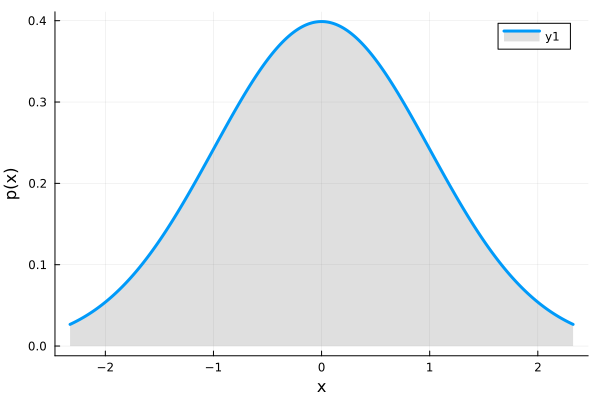

In [14]:
# single variable normal distribution with μ=1.0, σ=3.0

p = Normal(0.0, 1.0)

println("mean: ", mean(p))
println("stdev: ", std(p))

lo, hi = quantile.(p, [0.01, 0.99])
xs = range(lo, hi, length=500)

plot(xs, pdf.(p,xs), lw=3, fill=(0, :grey, 0.25))
xlabel!("x")
ylabel!("p(x)") 

In [15]:
# multivariate normal distribution with μ = [1.0 2.0] and 
# covariance matrix Σ

μ = [0.0, 0.25]
Σ = [2.0 1.0; 1.0 1.5]

p = MvNormal(μ, Σ)

println("mean: ", mean(p))
println("cov: ", cov(p))

mean: [0.0, 0.25]
cov: [2.0 1.0; 1.0 1.5]


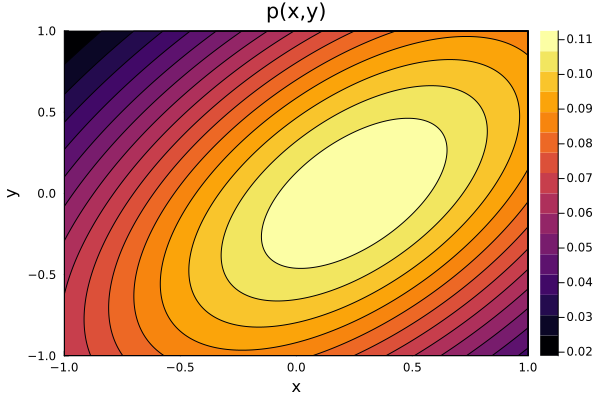

In [16]:
xs = -1:0.01:1 
ys = -1:0.01:1

res = [pdf(p, [xi, yi]) for xi ∈ xs, yi ∈ ys]

contourf(xs, ys, res, xlabel="x", ylabel="y", title="p(x,y)")

In [17]:
X, y, xs, ytrue = make_training_data(100, 10);

Let's begin our implementation by writing a kernel function. We'll use the RBF (squared error) kernel mentioned previously: 
\begin{equation}
    k(\mathbf{x},\mathbf{x}') = \sigma_f^2\exp\left(-\frac{1}{2\ell^2}(\mathbf{x}-\mathbf{x}')^2\right) + \sigma_n^2\delta_{\mathbf{x},\mathbf{x}'}
\end{equation}

In [18]:
# first define how to compute element i,j
function rbf_ij(X₁::AbstractMatrix, 
                X₂::AbstractMatrix,
                i::Int,
                j::Int,
                σf²::Float64, 
                ℓ::Float64
    )
    return σf²*exp(-(X₁[:,i] .- X₂[:,j])' * (X₁[:,i] .- X₂[:,j])/(2ℓ^2))
end

rbf_ij(X,X, 1, 2, 1.0, 0.1)

0.03199312802161347

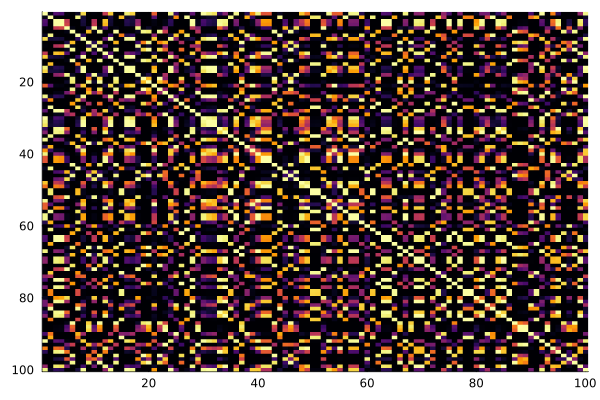

In [19]:
function RBF(
        X₁::AbstractMatrix,
        X₂::AbstractMatrix,
        σf²::Float64,
        ℓ::Float64
    )
    (d₁,n₁) = size(X₁)
    (d₂,n₂) = size(X₂)
    # we need to require d₁ == d₂
    K = zeros(n₁, n₂)
 
    @inline for j ∈ 1:n₂, i ∈ 1:n₁
        K[i,j] = rbf_ij(X₁, X₂, i, j, σf², ℓ)
    end
    
    return K 
end

heatmap(RBF(X,X, 1.0, 0.1), yflip=true, legend=false)

\begin{equation}
    p(\mathbf{f}_* \vert X_*, X, \mathbf{y} = \mathcal{N}\left( K_*^T\left[K + \sigma_n^2 I\right]^{-1}\mathbf{f},\; K_{**}-K_*^T\left[K + \sigma_n^2 I\right]^{-1}K_*\right)
\end{equation}

In [27]:
function gp_predict(Xₙ::AbstractMatrix, θ::AbstractVector)
    σₙ², σf², ℓ = θ
    K = Hermitian(RBF(X,X,σf², ℓ))
    Kₙ = RBF(X,Xₙ, σf², ℓ)  # not square 
    Kₙₙ = Hermitian(RBF(Xₙ, Xₙ, σf², ℓ))
    
    #L = cholesky(K+σₙ²*I)  # (K+σₙ²I) = LL'
    #α = L'\(L\y)  # Kₙ' α == Kₙ' inv(K+σₙ²I)y == Kₙ' inv(LL') y
    #v = L\Kₙ

    μ = Kₙ'*((K + σₙ²*I)\y)
    Σ = Kₙₙ - Kₙ'*((K + σₙ²*I)\Kₙ)
    
    p = MvNormal(μ, Σ)
    
    return p
end

function gp_predict(xₙ::Float64, θ::AbstractVector)
    gp_predict([xₙ;;], θ)
end


# try it out
xₙ = [0.25;;]
println(typeof(xₙ))
println(gp_predict(xₙ, [1.0, 1.0, 0.1]))

xₙ = 0.25
println(gp_predict(xₙ, [1.0, 1.0, 0.1]))


Matrix{Float64}
FullNormal(
dim: 1
μ: [0.026286545780166648]
Σ: [0.11209987761030293;;]
)

FullNormal(
dim: 1
μ: [0.026286545780166648]
Σ: [0.11209987761030293;;]
)



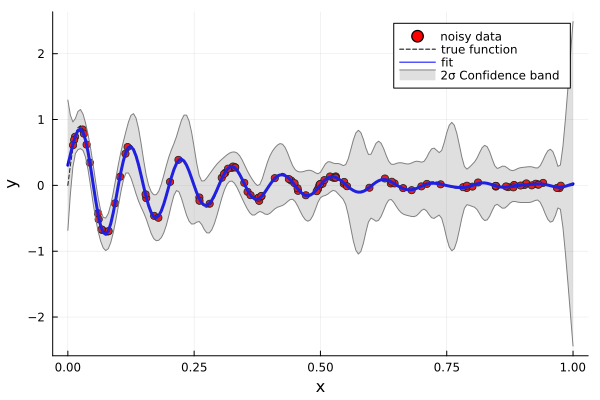

In [33]:
# visualize it
Xₙ = collect(xs)

# θ = [1.0, 1.0, 0.1]
# θ = [0.89, 1.16, 3.0]
θ = [0.25^2, 5.0, 0.03]

pₙ = [gp_predict(x, θ) for x ∈ Xₙ]
    
yₙ = vcat(mean.(pₙ)...)
σs = sqrt.(vcat(cov.(pₙ)...))

plot(X', y, seriestype=:scatter, color=:red, label="noisy data")
plot!(xs,ytrue, color=:black, linestyle=:dash, label="true function")
plot!(Xₙ, yₙ, color=:blue, linewidth=3, label="fit")
plot!(Xₙ, yₙ .+ 2 .* σs, c=:gray, label="")
plot!(Xₙ, yₙ .- 2 .* σs, fillrange = yₙ .+ 2 .* σs, fillalpha = 0.25, c = :gray, label = "2σ Confidence band")
xlabel!("x")
ylabel!("y")

Fantastic! We can see that the Gaussian Process has done an excellent job learning the functional form of the data. We also get an uncertainty estimate of our model for free! Not surprisingly, we observe that the error seems to be highest for points that are very far from training data. 

Things get better! We also saw that the output is highly sensative to the kernel hyperparameters $\theta$. It turns out there is a convenient way to select the *ideal* parameters once we've fit the predictive distribution. This is accomplished via the *marginal likelihood* (aka the *evidence*) $p(\mathbf{y}\vert X)$. By Marginalizing over the space of possible model functions, we find 

\begin{align}
    p(\mathbf{y}\vert X) &= \int p(\mathbf{y}\vert\mathbf{f}, X)p(\mathbf{f}\vert X) d\mathbf{f}
\end{align}

By definition of the Gaussian process with obersavtion noise included, we have that $\mathbf{y}\vert X \sim \mathcal{N}(\mathbf{0}, K+\sigma_n^2I)$. Taking the log for convenience of optimization, we find 
\begin{equation}
    \boxed{\log(p(\mathbf{y}\vert X)) = -\frac{1}{2}\mathbf{y}^T(K+\sigma_n^2I)^{-1}\mathbf{y} - \frac{1}{2}\log\lvert K + \sigma_n^2 I \rvert - \frac{n}{2}\log 2\pi}
\end{equation}
With the final two terms coming from the exponential prefactor 

# NOTE: remember Dr. Lary's method for preselection quantiles along input features and targets to reduce data volume before training.

Idea: Compute quantiles for features $X$ and target $\vec{y}$. Reduce your training data set to $\mathcal{D}:= (\tilde{X}, \tilde{y})$ so that each feature quantile has at least $n$ samples and each target quantile has at least $m >> n$ examples. The result is a uniform distribution across features and targets with as many duplicates removed as possible. 

# Bayesian Model Selection

Let us consider a *heirarchical* specification of models and their corresponding parameters. At the lowest level we have the parameters of an individual model, $\mathbf{w}$, e.g. the weights of a neural network or coefficients of a linear regression model. 

At the second level, we have model hyperparameters $\mathbf{\theta}$ which control the possible distribution of $\mathbf{w}$. For example, in an MLP neural network, this would be the number of hidden layers, nodes per layer, and choice of activation function. For our gaussian process regression the hyperparameters are the parameters of the chosen kernel function (e.g. $\sigma_n, \sigma_f, \ell$ for our RBF kernel).

At the top level is the (discrete) set of possible model structures $\mathcal{H}_i$. 

Returning to the base level, we can consider the *posterior* distribution over the vector of parameters $\mathbf{w}$, that is 
\begin{equation}
    p(\mathbf{w}\vert \mathcal{D},\theta,\mathcal{H}_i) = \dfrac{p(\mathcal{D}\vert\mathbf{w},\theta,\mathcal{H}_i)p(\mathcal{w}\vert \theta, \mathcal{H}_i)}{p(\mathcal{D}\vert \theta, \mathcal{H}_i)}
\end{equation}